## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pymysql
import os

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from dotenv import load_dotenv

import warnings
warnings.filterwarnings("ignore")

## Loading the data

In [2]:
# load environment variables from .env file
load_dotenv() 
password=os.environ.get('PyMySQL_PASSWORD')
db=os.environ.get('PyMySQL_db')
wd=os.environ.get("WorkingDir")
os.chdir(wd)

#connect to my local database in mysql
connection = pymysql.connect(host="localhost",
                             user="root",
                             password=password,
                             db=db,
                             port=3306,
                             autocommit=True)

In [3]:
def load_query(path):
    with open(path) as file:
        return file.read()

In [4]:
query = "SELECT * FROM website_sessions"
df_website_sessions = pd.read_sql_query(query,con = connection)

In [5]:
query = "SELECT * FROM orders"
df_orders = pd.read_sql_query(query,con = connection)

In [6]:
query = load_query('Daily_channels_growth.sql')
df_daily = pd.read_sql_query(query,con = connection)

## Data Understanding

In [7]:
df_website_sessions.describe()
## The describe function shows us the descriptive statistics of our data and the shape of dataset distribution

,website_session_id,user_id,is_repeat_session
count,472871.000000,472871.000000,472871.000000
mean,236436.000000,198037.970163,0.166119
std,136506.243908,111992.997798,0.372188
min,1.000000,1.000000,0.000000
25%,118218.500000,101966.500000,0.000000
50%,236436.000000,199483.000000,0.000000
75%,354653.500000,294433.000000,0.000000
max,472871.000000,394318.000000,1.000000


In [8]:
df_website_sessions.info()
## Using the info function we can see below that there are a few null values present in utm_source,utm_campaign,utm_content and http_referer column
## And we can also see the types of variables present in these columns. 
## The dataframe has 472871 rows and 9 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472871 entries, 0 to 472870
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   website_session_id  472871 non-null  int64         
 1   created_at          472871 non-null  datetime64[ns]
 2   user_id             472871 non-null  int64         
 3   is_repeat_session   472871 non-null  int64         
 4   utm_source          389543 non-null  object        
 5   utm_campaign        389543 non-null  object        
 6   utm_content         389543 non-null  object        
 7   device_type         472871 non-null  object        
 8   http_referer        432954 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 32.5+ MB


In [9]:
df_orders.describe()
## The describe function shows us the descriptive statistics of our data and the shape of dataset distribution

,order_id,website_session_id,user_id,primary_product_id,items_purchased,price_usd,cogs_usd
count,32313.000000,32313.000000,32313.000000,32313.000000,32313.000000,32313.000000,32313.000000
mean,16157.000000,258292.288707,215691.622629,1.392474,1.238666,59.991636,22.355406
std,9328.103961,132427.649842,108402.203189,0.732277,0.426274,17.808771,6.238621
min,1.000000,20.000000,13.000000,1.000000,1.000000,29.990000,9.490000
25%,8079.000000,144828.000000,124135.000000,1.000000,1.000000,49.990000,19.490000
50%,16157.000000,263554.000000,221461.000000,1.000000,1.000000,49.990000,19.490000
75%,24235.000000,374799.000000,310542.000000,2.000000,1.000000,59.990000,22.490000
max,32313.000000,472818.000000,394273.000000,4.000000,2.000000,109.980000,41.980000


In [10]:
df_orders.info()
## Using the info function we can see below that there are no null values presents in the dataframe
## And we can also see the types of variables present in these columns.
## The dataframe has 32313 rows and 8 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32313 entries, 0 to 32312
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            32313 non-null  int64         
 1   created_at          32313 non-null  datetime64[ns]
 2   website_session_id  32313 non-null  int64         
 3   user_id             32313 non-null  int64         
 4   primary_product_id  32313 non-null  int64         
 5   items_purchased     32313 non-null  int64         
 6   price_usd           32313 non-null  float64       
 7   cogs_usd            32313 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 2.0 MB


In [11]:
df_daily.describe()
## The describe function shows us the descriptive statistics of our data and the shape of dataset distribution

,yr,qtr,mo,wk,wkday,gsearch_nonbrand_websessions,bsearch_nonbrand_websessions,gsearch_brand_websessions,bsearch_brand_websessions,socialbook_pilot_websessions,socialbook_desktop_targeted_websessions,organic_search_websessions,direct_type_in_websessions
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,2013.212591,2.508212,6.522810,26.136861,2.994526,257.943431,50.099453,30.409672,7.220803,4.648723,5.100365,39.608577,36.420620
std,0.914353,1.117697,3.449496,15.122558,2.000449,226.331616,51.402718,27.087126,6.875180,19.745128,19.966798,34.055703,31.266874
min,2012.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012.000000,2.000000,4.000000,13.000000,1.000000,140.000000,26.000000,10.000000,2.000000,0.000000,0.000000,14.000000,12.000000
50%,2013.000000,3.000000,7.000000,26.000000,3.000000,209.000000,45.000000,21.000000,5.000000,0.000000,0.000000,28.000000,25.000000
75%,2014.000000,4.000000,10.000000,39.000000,5.000000,344.750000,69.000000,47.000000,11.000000,0.000000,0.000000,61.000000,56.000000
max,2015.000000,4.000000,12.000000,53.000000,6.000000,3503.000000,732.000000,240.000000,64.000000,117.000000,367.000000,200.000000,152.000000


In [12]:
df_daily.info()
## Using the info function we can see below that there are no null values presents in the dataframe
## And we can also see the types of variables present in these columns.
## The dataframe has 1096 rows and 14 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   yr                                       1096 non-null   int64
 1   qtr                                      1096 non-null   int64
 2   mo                                       1096 non-null   int64
 3   wk                                       1096 non-null   int64
 4   wkday                                    1096 non-null   int64
 5   gsearch_nonbrand_websessions             1096 non-null   int64
 6   bsearch_nonbrand_websessions             1096 non-null   int64
 7   gsearch_brand_websessions                1096 non-null   int64
 8   bsearch_brand_websessions                1096 non-null   int64
 9   socialbook_pilot_websessions             1096 non-null   int64
 10  socialbook_desktop_targeted_websessions  1096 non-null   int64
 11  orga

## Data Preprocessing

In [13]:
df_websess_orders = pd.merge(df_website_sessions,df_orders, on = ['website_session_id','user_id'], how = "left")
df_websess_orders.rename(columns = {'created_at_x': 'websess_date', 'created_at_y': 'orders_date' },inplace=True)
df_websess_orders['websess_date'] = pd.to_datetime(df_websess_orders['websess_date']).dt.normalize()
df_websess_orders.set_index('websess_date', inplace= True)

<Figure size 720x432 with 0 Axes>

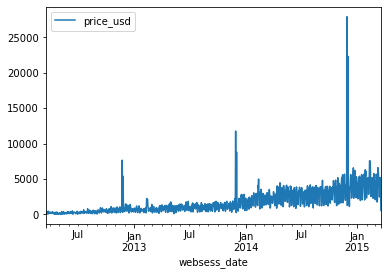

In [14]:
df_totsales = pd.Series.to_frame(df_websess_orders['price_usd'].groupby(df_websess_orders.index).sum())
df_daily.index = df_totsales.index

# using plot to see how presentable is the dataset
fig =plt.figure(figsize=(10,6))
df_totsales.plot(label='Total Sales in USD $', legend=True)
plt.show()

## Feature Engineering
### Adding Black Friday as binary variable

In [15]:
df_BlckFri = df_totsales.loc[['2012-11-23', '2013-11-29','2014-11-28'],'price_usd']
Black_Friday = pd.Series([1,1,1])
Black_Friday.index = df_BlckFri.index
df_BlckFri = pd.concat([df_BlckFri,Black_Friday], axis =1)
df_BlckFri.rename(columns = {0 :'Black_Friday'},inplace= True)

df_BlackFriday = df_daily.merge(df_BlckFri,how = 'left', on ='websess_date')
df_BlackFriday = df_BlackFriday.drop('price_usd', axis=1).fillna(0)

final_black_fri = pd.concat([df_totsales,df_BlackFriday],axis=1)
final_black_fri = final_black_fri[(final_black_fri.index >= '2012/04/01') & (final_black_fri.index <  '2015/03/01')]


In [16]:
final_black_fri.shape
## The dataframe has 1064 rows and 16 columns.

(1064, 15)

In [17]:
final_black_fri.describe()

,price_usd,yr,qtr,mo,wk,wkday,gsearch_nonbrand_websessions,bsearch_nonbrand_websessions,gsearch_brand_websessions,bsearch_brand_websessions,socialbook_pilot_websessions,socialbook_desktop_targeted_websessions,organic_search_websessions,direct_type_in_websessions,Black_Friday
count,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,1744.886541,2013.195489,2.553571,6.628759,26.593045,3.000000,256.082707,50.278195,29.985902,7.126880,4.788534,5.253759,38.992481,35.977444,0.002820
std,1824.000616,0.886471,1.102868,3.445635,15.112149,2.000941,227.061164,51.633137,26.409304,6.736254,20.023397,20.245192,32.963961,30.477348,0.053049
min,0.000000,2012.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,541.892500,2012.000000,2.000000,4.000000,14.000000,1.000000,139.000000,26.000000,10.000000,2.000000,0.000000,0.000000,14.000000,13.000000,0.000000
50%,1206.755000,2013.000000,3.000000,7.000000,27.000000,3.000000,208.500000,45.000000,21.000000,5.000000,0.000000,0.000000,28.000000,25.000000,0.000000
75%,2618.940000,2014.000000,4.000000,10.000000,40.000000,5.000000,333.500000,69.000000,46.000000,10.000000,0.000000,0.000000,60.000000,56.000000,0.000000
max,27892.130000,2015.000000,4.000000,12.000000,53.000000,6.000000,3503.000000,732.000000,240.000000,64.000000,117.000000,367.000000,200.000000,152.000000,1.000000


In [18]:
final_black_fri.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1064 entries, 2012-04-01 to 2015-02-28
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   price_usd                                1064 non-null   float64
 1   yr                                       1064 non-null   int64  
 2   qtr                                      1064 non-null   int64  
 3   mo                                       1064 non-null   int64  
 4   wk                                       1064 non-null   int64  
 5   wkday                                    1064 non-null   int64  
 6   gsearch_nonbrand_websessions             1064 non-null   int64  
 7   bsearch_nonbrand_websessions             1064 non-null   int64  
 8   gsearch_brand_websessions                1064 non-null   int64  
 9   bsearch_brand_websessions                1064 non-null   int64  
 10  socialbook_pilot_websessions  

## Lag Features

 ### Transform a time series dataset into a supervised learning dataset¶

In [19]:
 # create function to add lag features
def add_lags(df):
    target_map = df['price_usd'].to_dict()
    dataframe = pd.DataFrame()
    dataframe.index = df.index
    dataframe['lag1']=(df.index - pd.Timedelta('30 days')).map(target_map)
    dataframe['lag2']=(df.index - pd.Timedelta('61 days')).map(target_map)
    dataframe['lag3']=(df.index - pd.Timedelta('91 days')).map(target_map)
    dataframe['lag4']=(df.index - pd.Timedelta('122 days')).map(target_map)
    dataframe['lag5']=(df.index - pd.Timedelta('152 days')).map(target_map)
    dataframe['lag6']=(df.index - pd.Timedelta('183 days')).map(target_map)
    dataframe['lag7']=(df.index - pd.Timedelta('215 days')).map(target_map)
    dataframe['lag8']=(df.index - pd.Timedelta('244 days')).map(target_map)
    dataframe['lag9']=(df.index - pd.Timedelta('275 days')).map(target_map)
    dataframe['lag10']=(df.index - pd.Timedelta('306 days')).map(target_map)
    dataframe['lag11']=(df.index - pd.Timedelta('334 days')).map(target_map)
    dataframe['lag12']=(df.index - pd.Timedelta('365 days')).map(target_map)
    dataframe = pd.concat([dataframe,df['price_usd']], axis=1)
    return dataframe

In [20]:
lag_features = add_lags(final_black_fri)
# first 364 rows contain NaN value and are unusable, hence dataframe start from row 365
lag_features= lag_features[365:] # Note: dataframe starts from 2013-04-01

In [21]:
lag_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2013-04-01 to 2015-02-28
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lag1       699 non-null    float64
 1   lag2       699 non-null    float64
 2   lag3       699 non-null    float64
 3   lag4       699 non-null    float64
 4   lag5       699 non-null    float64
 5   lag6       699 non-null    float64
 6   lag7       699 non-null    float64
 7   lag8       699 non-null    float64
 8   lag9       699 non-null    float64
 9   lag10      699 non-null    float64
 10  lag11      699 non-null    float64
 11  lag12      699 non-null    float64
 12  price_usd  699 non-null    float64
dtypes: float64(13)
memory usage: 76.5 KB


### Select best lag features: 
#### Autocorrelation Plot (plot_acf()) from tsaplots

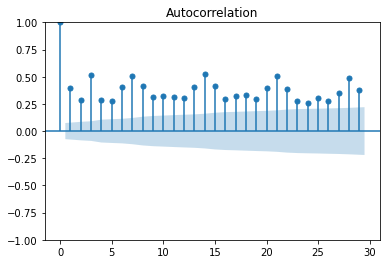

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(lag_features['price_usd'])
plt.show()
# no specific features stand out, further evaluation with feature importance in specific models, namely decision tree, random forest and xgboost regressor

## Decision Tree Regressor

### Feature Importance in Decision Tree Regressor

In [23]:
X = (lag_features.loc[:,lag_features.columns !='price_usd']).values
y = (lag_features['price_usd']).values

# fit decision tree model
dt_regressor = DecisionTreeRegressor(max_depth=9)
dt_regressor.fit(X, y)

DecisionTreeRegressor(max_depth=9)

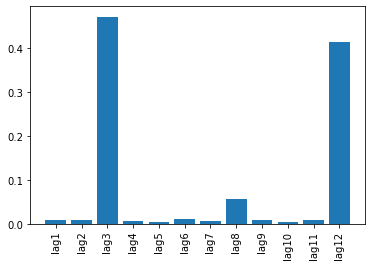

In [24]:
# show importance scores
names = lag_features.columns.values[0:-1]
ticks = [i for i in range(len(names))]

plt.bar(ticks, dt_regressor.feature_importances_)
plt.xticks(ticks, names, rotation=90)
plt.show()

### Feature Selection of Lag Variables: Recursive Feature Selection (RFE)

Selected Features:
lag3
lag8
lag12


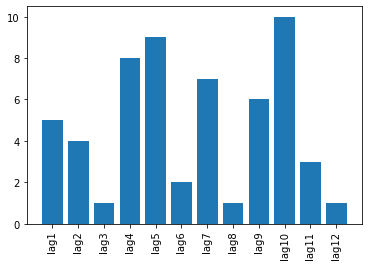

In [25]:
# perform feature selection
rfe = RFE(dt_regressor, n_features_to_select=3)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = lag_features.columns.values[0:-1]
for i in range(len(fit.support_)):
     if fit.support_[i]:
             print(names[i])
# plot feature rank (the lower the better)
names = lag_features.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names, rotation=90)
plt.show()

In [26]:
# adding selected features to the dataframe 
dt_selected_LagFeatures = lag_features[['lag3','lag8' ,'lag12']]
dt_selected_LagFeatures.index= pd.to_datetime(dt_selected_LagFeatures.index, format ='%Y-%m-%d')
dt_selected_LagFeatures = dt_selected_LagFeatures[(dt_selected_LagFeatures.index >= '2013-04-01') & (dt_selected_LagFeatures.index <  '2015/03/01')]

# adjusting final_black_fri dataframe to start/end as per the dates in lag_features data frame above
final_black_fri = final_black_fri[(final_black_fri.index >= '2013-04-01') & (final_black_fri.index <  '2015/03/01')]

# final dataframe for decision tree model
dt_df = pd.concat([final_black_fri,dt_selected_LagFeatures], axis=1) 

In [27]:
dt_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2013-04-01 to 2015-02-28
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   price_usd                                699 non-null    float64
 1   yr                                       699 non-null    int64  
 2   qtr                                      699 non-null    int64  
 3   mo                                       699 non-null    int64  
 4   wk                                       699 non-null    int64  
 5   wkday                                    699 non-null    int64  
 6   gsearch_nonbrand_websessions             699 non-null    int64  
 7   bsearch_nonbrand_websessions             699 non-null    int64  
 8   gsearch_brand_websessions                699 non-null    int64  
 9   bsearch_brand_websessions                699 non-null    int64  
 10  socialbook_pilot_websessions   

### Time Series Train Test Split & K-fold Cross Validation

In [28]:
tss = TimeSeriesSplit(n_splits=3, test_size = 90)
dt_df = dt_df.sort_index()

fold= 0
dt_preds = []
dt_scores = []
dt_r2scores = []
dt_mae = []
dt_mse = []


for train_idx, val_idx in tss.split(dt_df):
    train = dt_df.iloc[train_idx]
    test=dt_df.iloc[val_idx]
   
    FEATURES = ['yr','qtr','mo','wk',
       'gsearch_nonbrand_websessions', 'bsearch_nonbrand_websessions','gsearch_brand_websessions', 
       'bsearch_brand_websessions','socialbook_pilot_websessions','socialbook_desktop_targeted_websessions', 
       'organic_search_websessions','direct_type_in_websessions', 'Black_Friday', 'lag3', 'lag8', 'lag12']
    TARGET = ['price_usd']

    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    dt_regressor=DecisionTreeRegressor(max_depth=9)
    dt_regressor.fit(X_train, y_train)
    y_pred= dt_regressor.predict(X_test)
    dt_preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    dt_scores.append(score)
    r2score=r2_score(y_test, y_pred)
    dt_r2scores.append(r2score)
    mae=mean_absolute_error(y_test, y_pred)
    dt_mae.append(mae)
    mse=mean_squared_error(y_test, y_pred)
    dt_mse.append(mse)
    
    fold +=1

print('r2_score: ',dt_r2scores)
print('mean_absolute_error: ',dt_mae)
print('mean_squared_error: ',dt_mse)
print('root_mean_squared_error: ',dt_scores)

r2_score:  [-0.3787983591758084, 0.5248953979570243, -0.9419300315612436]
mean_absolute_error:  [835.2517991181656, 891.5689397191155, 2387.724763163565]
mean_squared_error:  [1100236.1753775268, 3780401.178570492, 10749578.746419432]
root_mean_squared_error:  [1048.921434320763, 1944.3253787806434, 3278.655020952865]


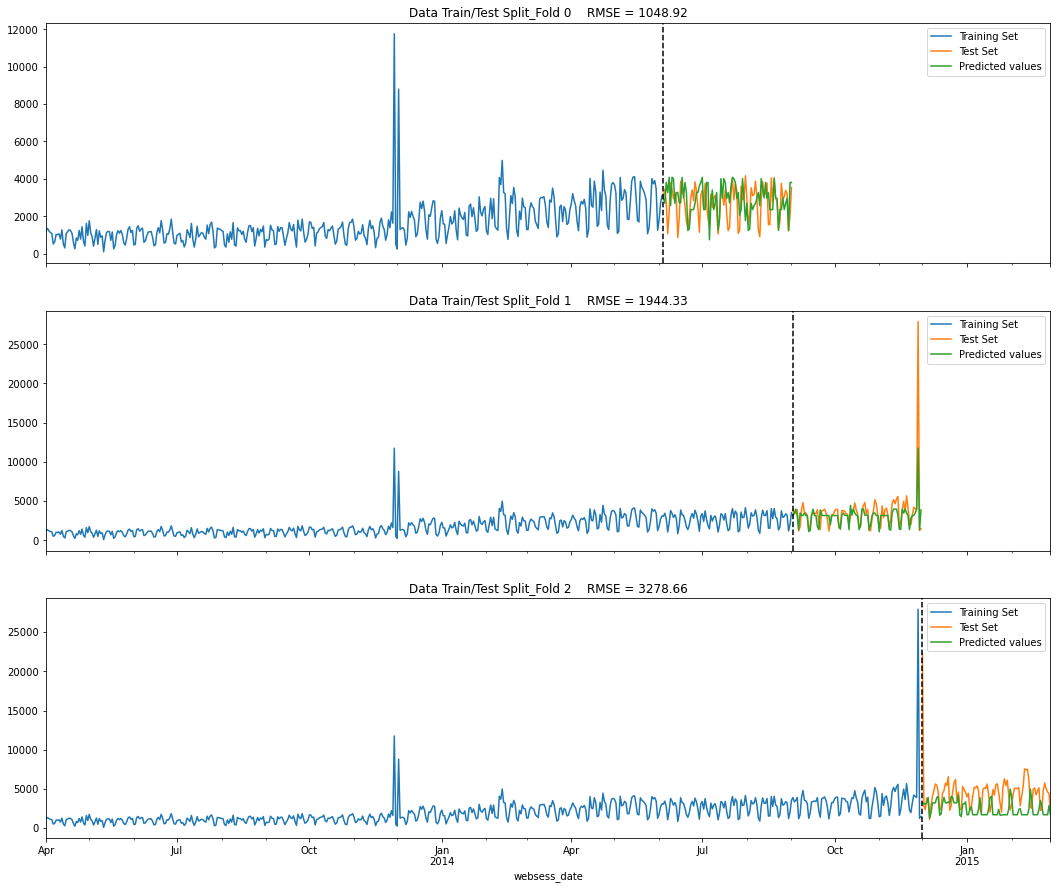

In [29]:
fig, axs = plt.subplots(nrows= 3, ncols = 1, figsize=(18,15),
                       sharex = True)

fold= 0


for train_idx, val_idx in tss.split(dt_df):
    train = dt_df.iloc[train_idx]
    test=dt_df.iloc[val_idx]
    
       
    train['price_usd'].plot(ax=axs[fold],
                           title = f'Data Train/Test Split_Fold {fold}    RMSE = {dt_scores[fold]:.2f}')
    test['price_usd'].plot(ax=axs[fold])
    dt_preds[fold] =pd.DataFrame(dt_preds[fold])
    dt_preds[fold] = dt_preds[fold].rename_axis(None, axis=1)
    dt_preds[fold].index = test.index
    dt_preds[fold].plot(ax=axs[fold])
    axs[fold].legend(labels=['Training Set','Test Set','Predicted values'],loc ='upper right')
    axs[fold].axvline(test.index.min(),color = 'black', ls ='--')
    fold +=1
plt.show()

## Random Forest Regressor

### Feature Importance in Decision Tree Regressor

In [30]:
X = (lag_features.loc[:,lag_features.columns !='price_usd']).values
y = (lag_features['price_usd']).values

# fit decision tree model
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X, y)

RandomForestRegressor()

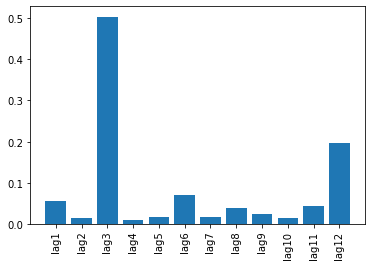

In [31]:
# show importance scores
names = lag_features.columns.values[0:-1]
ticks = [i for i in range(len(names))]

plt.bar(ticks, rf_regressor.feature_importances_)
plt.xticks(ticks, names, rotation=90)
plt.show()

### Feature Selection of Lag Variables: Recursive Feature Selection (RFE)

Selected Features:
lag3
lag6
lag12


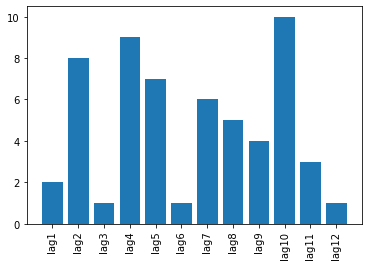

In [32]:
# perform feature selection
rfe = RFE(rf_regressor, n_features_to_select=3)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = lag_features.columns.values[0:-1]
for i in range(len(fit.support_)):
     if fit.support_[i]:
             print(names[i])
# plot feature rank (the lower the better)
names = lag_features.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names, rotation=90)
plt.show()

In [34]:
# adding selected features to the dataframe 
rf_selected_LagFeatures = lag_features[['lag3','lag6' ,'lag12']]
rf_selected_LagFeatures.index= pd.to_datetime(rf_selected_LagFeatures.index, format ='%Y-%m-%d')
rf_selected_LagFeatures = rf_selected_LagFeatures[(rf_selected_LagFeatures.index >= '2013-04-01') & (rf_selected_LagFeatures.index <  '2015/03/01')]

# adjusting final_black_fri dataframe to start/end as per the dates in lag_features data frame above
final_black_fri = final_black_fri[(final_black_fri.index >= '2013-04-01') & (final_black_fri.index <  '2015/03/01')]

# final dataframe for random forest model
rf_df = pd.concat([final_black_fri,rf_selected_LagFeatures], axis=1) 

In [35]:
rf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2013-04-01 to 2015-02-28
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   price_usd                                699 non-null    float64
 1   yr                                       699 non-null    int64  
 2   qtr                                      699 non-null    int64  
 3   mo                                       699 non-null    int64  
 4   wk                                       699 non-null    int64  
 5   wkday                                    699 non-null    int64  
 6   gsearch_nonbrand_websessions             699 non-null    int64  
 7   bsearch_nonbrand_websessions             699 non-null    int64  
 8   gsearch_brand_websessions                699 non-null    int64  
 9   bsearch_brand_websessions                699 non-null    int64  
 10  socialbook_pilot_websessions   

### Time Series Train Test Split & K-fold Cross Validation

In [36]:
tss = TimeSeriesSplit(n_splits=3, test_size = 90)
rf_df = rf_df.sort_index()

fold= 0
rf_preds = []
rf_scores = []
rf_r2scores = []
rf_mae = []
rf_mse = []



for train_idx, val_idx in tss.split(rf_df):
    train = rf_df.iloc[train_idx]
    test=rf_df.iloc[val_idx]
   
    FEATURES = ['yr','qtr','mo','wk',
       'gsearch_nonbrand_websessions', 'bsearch_nonbrand_websessions',
       'gsearch_brand_websessions', 'bsearch_brand_websessions','organic_search_websessions',
       'direct_type_in_websessions', 'lag3', 'lag6', 'lag12','Black_Friday']
    TARGET = ['price_usd']

    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    #rf_reg = RandomForestRegressor()
    rf_regressor.fit(X_train, y_train)
            #eval_set = [(X_train, y_train),(X_test,y_test)],
            #verbose = 100)
    y_pred= rf_regressor.predict(X_test)
    rf_preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    rf_scores.append(score)
    r2score=r2_score(y_test, y_pred)
    rf_r2scores.append(r2score)
    mae=mean_absolute_error(y_test, y_pred)
    rf_mae.append(mae)
    mse=mean_squared_error(y_test, y_pred)
    rf_mse.append(mse)
 
    fold +=1
    
print('r2_score: ',rf_r2scores)
print('mean_absolute_error: ',rf_mae)
print('mean_squared_error: ',rf_mse)
print('root_mean_squared_error: ',rf_scores)

r2_score:  [0.17550388453840426, 0.3052623358619325, -0.07158304664268433]
mean_absolute_error:  [614.6131888888892, 903.0523255555551, 1428.0016100000003]
mean_squared_error:  [657921.041646254, 5528018.6152928285, 5931761.781320544]
root_mean_squared_error:  [811.1233208620339, 2351.1738802761543, 2435.5208439511543]


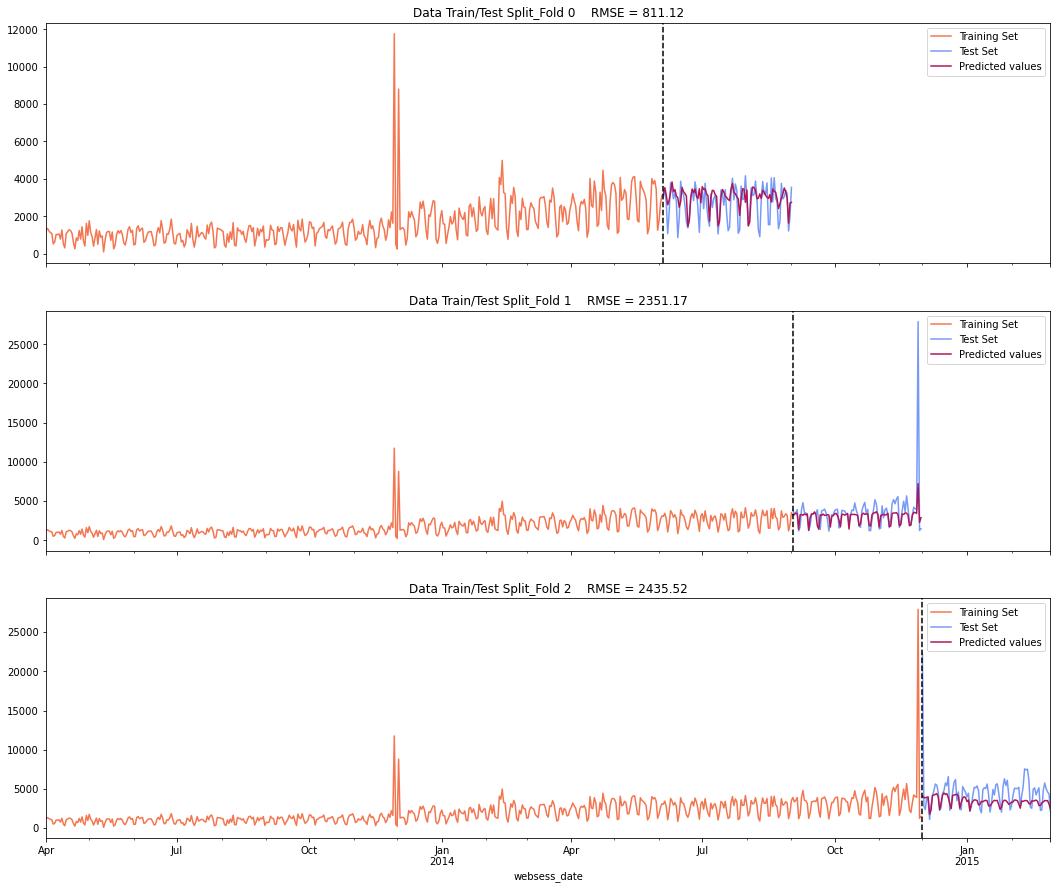

In [37]:
fig, axs = plt.subplots(nrows= 3, ncols = 1, figsize=(18,15),
                       sharex = True)

fold= 0
colors = ['#f37651',  '#779af7','#ad1759'] 

for train_idx, val_idx in tss.split(rf_df):
    train = rf_df.iloc[train_idx]
    test=rf_df.iloc[val_idx]
    
       
    train['price_usd'].plot(ax=axs[fold], color = colors[0],
                           title = f'Data Train/Test Split_Fold {fold}    RMSE = {rf_scores[fold]:.2f}')
    test['price_usd'].plot(ax=axs[fold],color = colors[1])
    rf_preds[fold] =pd.DataFrame(rf_preds[fold])
    rf_preds[fold].index = test.index
    rf_preds[fold].plot(ax=axs[fold],color = colors[2])
    axs[fold].legend(labels=['Training Set','Test Set','Predicted values'],loc ='upper right')
    axs[fold].axvline(test.index.min(),color = 'black', ls ='--')
    fold +=1
plt.show()

#### The Random Forest Regressor is better compared to Decision Tree Regressor as it can be observed that the overall root mean square error is less as compared to the previous model.



## XGBoost Regressor

### Feature Importance in xgboost model

In [38]:
X = (lag_features.loc[:,lag_features.columns !='price_usd']).values
y = (lag_features['price_usd']).values

# fit XGBoost model
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

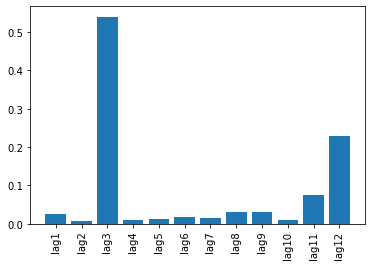

In [39]:
# show importance scores
names = lag_features.columns.values[0:-1]
ticks = [i for i in range(len(names))]

plt.bar(ticks, xgb_regressor.feature_importances_)
plt.xticks(ticks, names, rotation=90)
plt.show()

### Feature Selection of Lag Variables: Recursive Feature Selection (RFE)

Selected Features:
lag3
lag11
lag12


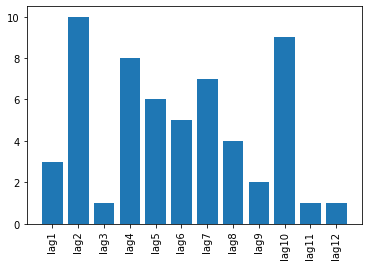

In [40]:
# perform feature selection
rfe = RFE(xgb_regressor, n_features_to_select=3)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = lag_features.columns.values[0:-1]
for i in range(len(fit.support_)):
     if fit.support_[i]:
             print(names[i])
# plot feature rank (the lower the better)
names = lag_features.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names, rotation=90)
plt.show()

In [41]:
# adding selected features to the dataframe 
xgb_selected_LagFeatures = lag_features[['lag3','lag11' ,'lag12']]
xgb_selected_LagFeatures.index= pd.to_datetime(xgb_selected_LagFeatures.index, format ='%Y-%m-%d')
xgb_selected_LagFeatures = xgb_selected_LagFeatures[(xgb_selected_LagFeatures.index >= '2013-04-01') & (xgb_selected_LagFeatures.index <  '2015/03/01')]

# adjusting final_black_fri dataframe to start/end as per the dates in lag_features data frame above
final_black_fri = final_black_fri[(final_black_fri.index >= '2013-04-01') & (final_black_fri.index <  '2015/03/01')]

# final dataframe for random forest model
xgb_df = pd.concat([final_black_fri,xgb_selected_LagFeatures], axis=1) 

In [42]:
xgb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2013-04-01 to 2015-02-28
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   price_usd                                699 non-null    float64
 1   yr                                       699 non-null    int64  
 2   qtr                                      699 non-null    int64  
 3   mo                                       699 non-null    int64  
 4   wk                                       699 non-null    int64  
 5   wkday                                    699 non-null    int64  
 6   gsearch_nonbrand_websessions             699 non-null    int64  
 7   bsearch_nonbrand_websessions             699 non-null    int64  
 8   gsearch_brand_websessions                699 non-null    int64  
 9   bsearch_brand_websessions                699 non-null    int64  
 10  socialbook_pilot_websessions   

### Time Series Train Test Split & K-fold Cross Validation

In [43]:
tss = TimeSeriesSplit(n_splits=3, test_size = 90)
xgb_df = xgb_df.sort_index()

fold= 0
xgb_preds = []
xgb_scores = []
xgb_r2scores = []
xgb_mae = []
xgb_mse = []

for train_idx, val_idx in tss.split(xgb_df):
    train = xgb_df.iloc[train_idx]
    test=xgb_df.iloc[val_idx]
   
    FEATURES = ['yr','qtr','mo','wk',
       'gsearch_nonbrand_websessions', 'bsearch_nonbrand_websessions',
       'gsearch_brand_websessions', 'bsearch_brand_websessions','organic_search_websessions',
       'direct_type_in_websessions', 'lag3', 'lag11', 'lag12','Black_Friday']
    TARGET = ['price_usd']

    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(X_train, y_train, 
            eval_set = [(X_train, y_train),(X_test,y_test)],
            verbose = 100)
    y_pred= xgb_reg.predict(X_test)
    xgb_preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    xgb_scores.append(score)
    r2score=r2_score(y_test, y_pred)
    xgb_r2scores.append(r2score)
    mae=mean_absolute_error(y_test, y_pred)
    xgb_mae.append(mae)
    mse=mean_squared_error(y_test, y_pred)
    xgb_mse.append(mse)
 
    fold +=1

print('r2_score: ',xgb_r2scores)
print('mean_absolute_error: ',xgb_mae)
print('mean_squared_error: ',xgb_mse)
print('root_mean_squared_error: ',xgb_scores)

[0]	validation_0-rmse:1447.11392	validation_1-rmse:2020.54994
[99]	validation_0-rmse:3.49349	validation_1-rmse:796.28953
[0]	validation_0-rmse:1570.60625	validation_1-rmse:3883.01457
[99]	validation_0-rmse:6.85642	validation_1-rmse:2015.70460
[0]	validation_0-rmse:1984.54254	validation_1-rmse:4228.31460
[99]	validation_0-rmse:14.56421	validation_1-rmse:2494.48228
r2_score:  [0.2053848083418447, 0.4893714619090832, -0.12409479947968816]
mean_absolute_error:  [604.830366265191, 949.9059762369793, 1476.7504127604166]
mean_squared_error:  [634077.0378414505, 4063064.6786200064, 6222441.266708627]
root_mean_squared_error:  [796.2895439734535, 2015.70451173281, 2494.482164038987]


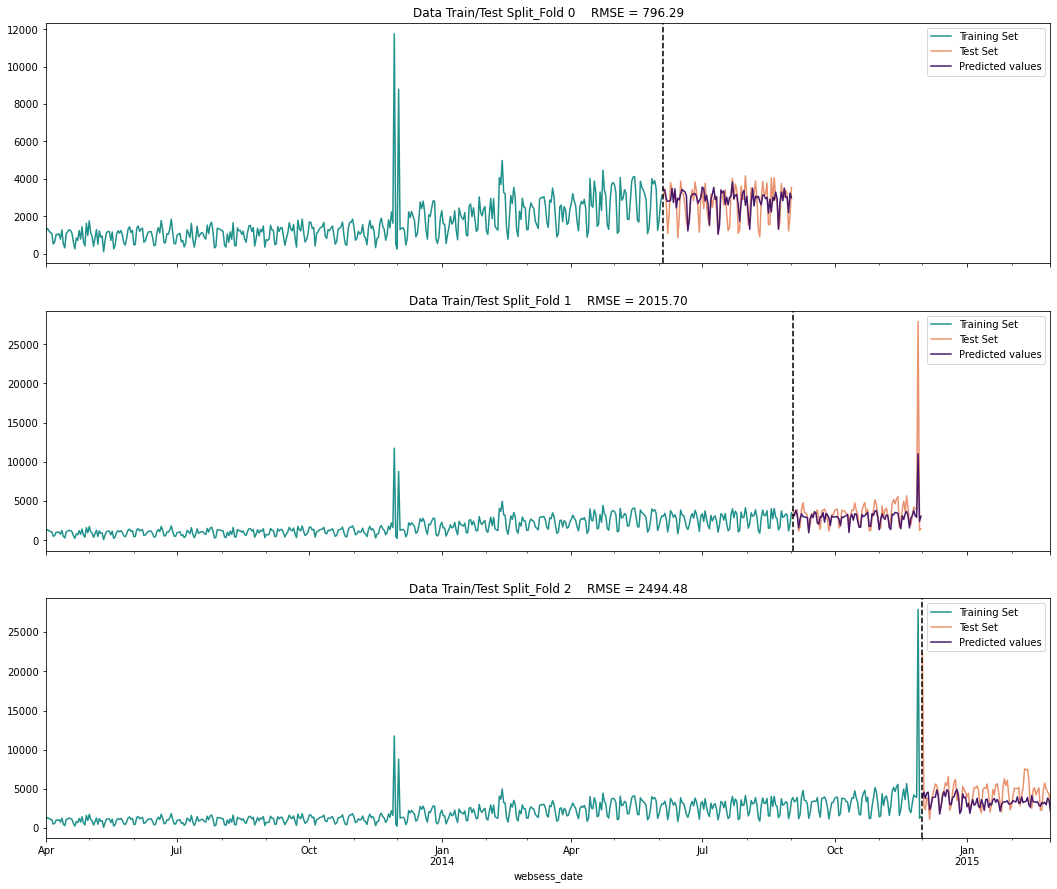

In [44]:
fig, axs = plt.subplots(nrows= 3, ncols = 1, figsize=(18,15),
                       sharex = True)

fold= 0
colors =[ '#21918c','#ea926e', '#48186a'] 


for train_idx, val_idx in tss.split(xgb_df):
    train = xgb_df.iloc[train_idx]
    test= xgb_df.iloc[val_idx]
    
       
    train['price_usd'].plot(ax=axs[fold],color=colors[0],
                           title = f'Data Train/Test Split_Fold {fold}    RMSE = {xgb_scores[fold]:.2f}')
    test['price_usd'].plot(ax=axs[fold], color = colors[1])
    xgb_preds[fold] =pd.DataFrame(xgb_preds[fold])
    xgb_preds[fold].index = test.index
    xgb_preds[fold].plot(ax=axs[fold],color =colors[2])
    axs[fold].legend(labels=['Training Set','Test Set','Predicted values'],loc ='upper right')
    axs[fold].axvline(test.index.min(),color = 'black', ls ='--')
    fold +=1
plt.show()

#### The XGBoost Regressor is better compared to Random Forest Regressor as it can be observed that the overall root mean square error is less as compared to the previous model.

## Hyperparameter tuning with RandomSearch/GridSearch in Sklearn

In [45]:
# define a list of parameters for the models
params = {'learning_rate': [0.001, 0.01,0.1,0.25, 0.4, 0.5],
          'max_depth': [10,20,30,40,50,60],
          'early_stopping_rounds': [25,50,75,100],
          'max_features': [1,2,3,4,5,6],
          'n_estimators': [200,400,700,1000]
    
}

### RandomSearchCV

In [47]:
# cv=5 means 5-fold cross validation
random_search = RandomizedSearchCV(xgb_reg, param_distributions=params,cv=5, n_jobs = 1, verbose =0)

### 80 percent data is used for training purpose and 20 percent is used for testing.

In [48]:
n_test= int(len(xgb_df)*(1- 0.2)) # 0.2 is tge percentage of the split

train_cv = xgb_df[:n_test]
test_cv = xgb_df[n_test:]

X_train_cv = train_cv.loc[:,train_cv.columns!='price_usd']
y_train_cv = train_cv['price_usd']

X_test_cv = test_cv.loc[:,test_cv.columns!='price_usd']
y_test_cv = test_cv['price_usd']

In [49]:
random_search.fit(X_train_cv,y_train_cv,
                 eval_set = [(X_train_cv, y_train_cv),(X_test_cv,y_test_cv)],
                 verbose =100)

[15:23:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[0]	validation_0-rmse:2210.23290	validation_1-rmse:5166.12440
[100]	validation_0-rmse:959.91162	validation_1-rmse:3752.55199
[200]	validation_0-rmse:495.42786	validation_1-rmse:3239.29900
[300]	validation_0-rmse:317.59632	validation_1-rmse:2978.08542
[400]	validation_0-rmse:256.77238	validation_1-rmse:2848.86563
[500]	validation_0-rmse:235.45640	validation_1-rmse:2781.16049
[600]	validation_0-rmse:228.56332	validation_1-rmse:2752.06464
[700]	validation_0-rmse:226.25028	validation_1-rmse:2731.84832
[800]	validation_0-rmse:225.40279	validation_1-rmse:2720.32156
[900]	validation_0-rmse:225.07534	validation_1-rmse:2712.70165
[999]	validation_0-rmse:224.96311	validation_1-rmse:2709.00653
[15:23:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-

[200]	validation_0-rmse:285.91625	validation_1-rmse:2678.87177
[209]	validation_0-rmse:285.91625	validation_1-rmse:2678.87178
[15:23:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[0]	validation_0-rmse:1742.82271	validation_1-rmse:4620.14611
[100]	validation_0-rmse:408.72516	validation_1-rmse:2767.61006
[200]	validation_0-rmse:408.72520	validation_1-rmse:2767.60942
[209]	validation_0-rmse:408.72520	validation_1-rmse:2767.60942
[15:23:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[0]	validation_0-rmse:2030.21180	validation_1-rmse:4952.63031
[100]	validation_0-rmse:230.57757	validation_1-rmse:2719.11111
[199]	validation_0-rmse:230.47659	validation_1-rmse:2715.42773
[15:23:53] WARNING: C:/buildkit

[100]	validation_0-rmse:2042.12660	validation_1-rmse:4947.35641
[200]	validation_0-rmse:1873.84822	validation_1-rmse:4733.37728
[300]	validation_0-rmse:1720.56449	validation_1-rmse:4542.05407
[399]	validation_0-rmse:1584.14054	validation_1-rmse:4373.14139
[15:24:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[0]	validation_0-rmse:2228.34057	validation_1-rmse:5187.76389
[100]	validation_0-rmse:2042.14110	validation_1-rmse:4970.23561
[200]	validation_0-rmse:1874.19277	validation_1-rmse:4774.67052
[300]	validation_0-rmse:1722.32420	validation_1-rmse:4598.34202
[399]	validation_0-rmse:1585.83251	validation_1-rmse:4440.58984
[15:24:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[0]	validation_0-rmse:

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_jobs=1,
                   param_distributions={'early_stopping_rounds': [25, 50, 75,
                                                                  100],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.25, 0.4, 0.5],
                                        'max_depth': [10, 20, 30, 40, 50, 60],
                                        'max_features': [1, 2, 3, 4, 5, 6],
                                        'n_estimators': [200, 400, 700, 1000]})

In [50]:
print(random_search.best_params_)

{'n_estimators': 700, 'max_features': 1, 'max_depth': 40, 'learning_rate': 0.25, 'early_stopping_rounds': 100}


In [39]:
from sklearn.tree import DecisionTreeRegressor

## Time Series Train Test Split & K-fold Cross Validation

### XGBoost Regressor with tuned hyperparameters

In [58]:
tss = TimeSeriesSplit(n_splits=3, test_size = 90)
df = xgb_df.sort_index()

fold= 0
preds = []
scores = []
r2scores = []
maes = []
mses = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test=df.iloc[val_idx]
   
    FEATURES = ['yr','qtr','mo','wk',
       'gsearch_nonbrand_websessions', 'bsearch_nonbrand_websessions',
       'gsearch_brand_websessions', 'bsearch_brand_websessions','organic_search_websessions',
       'direct_type_in_websessions', 'lag3', 'lag11', 'lag12','Black_Friday']
    TARGET = ['price_usd']

    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(n_estimators = 700, 
                           early_stopping_rounds = 100,
                           max_features= 1, 
                           max_depth= 40,
                          learning_rate = 0.25)
    reg.fit(X_train, y_train, 
            eval_set = [(X_train, y_train),(X_test,y_test)],
            verbose = 100)
    y_pred= reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    r2score=r2_score(y_test, y_pred)
    r2scores.append(r2score)
    mae=mean_absolute_error(y_test, y_pred)
    maes.append(mae)
    mse=mean_squared_error(y_test, y_pred)
    mses.append(mse)
 
    fold +=1

print('r2_score: ',r2scores)
print('mean_absolute_error: ',maes)
print('mean_squared_error: ',mses)
print('root_mean_squared_error: ',scores)

[15:36:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[0]	validation_0-rmse:1529.44592	validation_1-rmse:2156.98418
[100]	validation_0-rmse:0.00119	validation_1-rmse:774.75424
[113]	validation_0-rmse:0.00056	validation_1-rmse:774.75424
[15:36:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[0]	validation_0-rmse:1662.70882	validation_1-rmse:3987.44349
[100]	validation_0-rmse:0.00115	validation_1-rmse:1971.13256
[200]	validation_0-rmse:0.00056	validation_1-rmse:1971.13147
[211]	validation_0-rmse:0.00055	validation_1-rmse:1971.13148
[15:36:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: {

#### The tuned XGBoost Regressor perfom better compared to earlier model as it can be observed that the overall root mean square error is less as compared to the previous XGBoost model.

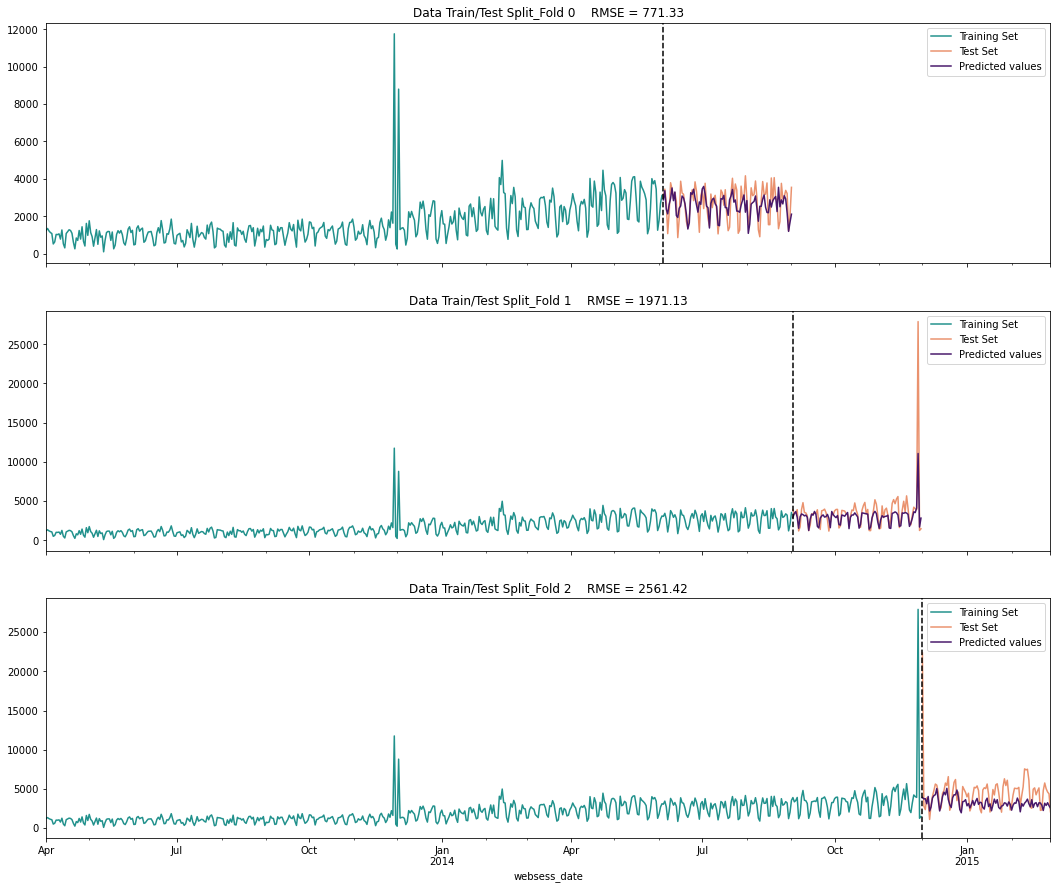

In [60]:
fig, axs = plt.subplots(nrows= 3, ncols = 1, figsize=(18,15),
                       sharex = True)

fold= 0
colors =[ '#21918c','#ea926e', '#48186a'] 

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test=df.iloc[val_idx]
    
       
    train['price_usd'].plot(ax=axs[fold],color = colors[0],
                           title = f'Data Train/Test Split_Fold {fold}    RMSE = {scores[fold]:.2f}')
    test['price_usd'].plot(ax=axs[fold],color = colors[1])
    preds[fold] =pd.DataFrame(preds[fold])
    preds[fold].index = test.index
    preds[fold].plot(ax=axs[fold],color = colors[2])
    axs[fold].legend(labels=['Training Set','Test Set','Predicted values'],loc ='upper right')
    axs[fold].axvline(test.index.min(),color = 'black', ls ='--')
    fold +=1
plt.show()

### XGBoost Regressor perform better after tuning its hyperparameters. However, in order to improve the XGBoost regressor model further, bigger dataset is required for training/tuning the model further.